In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import os, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, image_dataset_from_directory, array_to_img, img_to_array

from pathlib import Path

In [3]:
image_dir = Path('/content/drive/MyDrive/Colab Notebooks/test_images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df.head(3)

,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/test_im...,Common wheat
1,/content/drive/MyDrive/Colab Notebooks/test_im...,Common wheat
2,/content/drive/MyDrive/Colab Notebooks/test_im...,Common wheat


In [ ]:
image_df.shape

(5539, 2)

In [5]:
batch_size = 32
img_height = 256
img_width = 256

In [12]:
train_ds = image_dataset_from_directory(
  image_dir,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  image_dir,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5539 files belonging to 12 classes.
Using 4432 files for training.
Found 5539 files belonging to 12 classes.
Using 1107 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


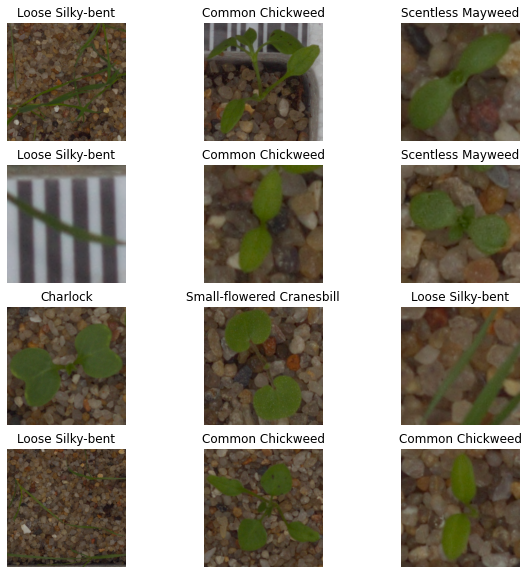

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
normalize_layer = Rescaling(1./255)

In [20]:
normalized_train = train_ds.map(lambda x, y: (normalize_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train))

In [27]:
AUTOTUNE = AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)